# Итоговая работа | Задача №5 — Классификация и кластеризация телефонного мошенничества

## Введение (Intro)

Задача от МТС-Защитник
Объём телефонного мошенничества достигает 20 млн звонков в день и сотен миллиардов рублей убытков в год. В борьбе с телефонным мошенничеством заинтересованы как банки — для предотвращения потенциальных потерь, — так и правоохранительные органы. Современные схемы мошенничества стали куда сложнее, чем уже классические “службы безопасности Сбербанка”, и могут состоять из цепи звонков потенциальной жертве. В свете этих причин в МТС-Защитнике появилось направление антифрода, цель которого — борьба с телефонным мошенничеством.

Вам необходимо: Вам предлагается решить задачу по классификации и кластеризации телефонного мошенничества.
Для этого нужно:
собрать датасет из мошеннических и немошеннических звонков
сделать классификатор звонков и выполнить кластеризацию мошеннических паттернов

Телефонные разговоры являются тайной связи, поэтому вам предлагается работать с открытыми источниками. В интернете есть достаточно большой объём записей мошеннических разговоров.

*P.s. про большое количество спорный момент, ибо адекватных и не так много, а хорошие данные являются платными, причём и на английском, и на русском.*

### Описание собранных данных

- `url` — либо ссылка на видео, либо синтетическая запись ссылки;
- `title` — либо название видео, либо указание на синтетическое происхождение данных;
- `chapter_title` — уточнение темы звонка/текста, в строках, которые запарсил из видео, это "эпизод" (как его называют на YouTube) из видео, с его названием с платформы; 
- `text` — текст разговора, представляющий из себя автоматические субтитры с платформы YouTube;
- `label` — класс: мошенническая/не мошенническая метка.

**Ещё о датасете:**
- Не уверен в полной корректности данного датасета, но после поисков примеров, предобработки и генерации примеров выглядит, вроде, не плохо.
- Говоря о источниках данных:
    - 117 строк мошеннических примеров из YouTube, один пример при ручной проверке убрал, а также пофиксил пересечения текстов разных "эпизодов" внутри одного видео — везде автоперевод, так что наслаивается так;
    - Данные я парсил и сразу в этом скрипте чистил от [музыка] и тому подобное, а также иных символов;
    - Из реальных данных ещё 3 примера холодных звонков с YouTube, которые, возможно, не совсем вписывались в формат входящих звонков, но по логике подходили;
    - Так как на это очень небольшое количество реальных данных я потратил кучу времени (и больше ничего особо полезного не нашёл), так что остальные я генерировал через промты в GPT-5 — с этим тоже долго пришлось повозиться, ибо даже на основе примеров, что я ему дал, он предпочитал генерировать пару фраз, а потом прогонять генерацией кода однотипные фразы. В конечном счёте, я понял как от него добиваться именно генерации и подбором пришёл к нынешним примерам.
- Подробно о датасете я распишу в EDA-анализе ниже, а также обработаю текста для более корректного обучения.

### Импорт библиотек

In [64]:
import os
import math
import random
from dataclasses import dataclass, asdict, replace
from typing import Any, Dict, List, Tuple, Optional

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn.metrics import (
    average_precision_score,
    precision_recall_curve,
    precision_score,
    recall_score,
    f1_score,
    brier_score_loss,
    confusion_matrix,
)
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    AutoModel,
    get_linear_schedule_with_warmup,
)
from peft import LoraConfig, get_peft_model, TaskType
from tqdm.auto import tqdm
from IPython.display import display
import warnings

# Визуализация
import matplotlib.pyplot as plt
import seaborn as sns
import mplcyberpunk

# Кластеризация и снижение размерности
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.calibration import calibration_curve
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import trustworthiness

# Вынесенный в модули код
import scripts.eda_analysis as ea
import scripts.preprocessing as pp
import scripts.model_training as mt
import scripts.visualization as vl
import scripts.clusterixation as cl
from scripts.config_moments import base_cfg, seed_everything

# Полезные флаги окружения и настройки
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
warnings.filterwarnings("ignore")

In [65]:
seed_everything(42)
print("Инициализация завершена")

Инициализация завершена


### Базовая конфигурация

In [66]:
@dataclass
class TrainConfig:
    model_name: str = "DeepPavlov/rubert-base-cased-conversational"
    text_col: str = "text"
    label_col: str = "label"
    max_length: int = 384
    batch_size: int = 16
    epochs: int = 4
    lr: float = 2e-5
    weight_decay: float = 0.01
    warmup_prop: float = 0.1
    dropout: float = 0.2
    grad_clip_norm: float = 1.0
    use_amp: bool = True
    use_lora: bool = True
    lora_r: int = 8
    lora_alpha: int = 16
    lora_dropout: float = 0.1
    loss_type: str = "bce"
    focal_gamma: float = 2.0
    focal_alpha: float = 0.25
    target_precision: float = 0.90
    device: str = "cuda" if torch.cuda.is_available() else "cpu"
    seed: int = 42

    # Параметры DataLoader
    num_workers: int = 0
    pin_memory: bool = True
    persistent_workers: bool = False
    prefetch_factor: int | None = None

# Более хорошая попытка по метрикам на длинной модели от Сбера, но на kaggle постоянно падал.
# Причина в том, что RAM переполнялось — все веса модели при кросс-валидации сохранялись, но времени для исправление у меня нет, да и я пока не полностью понял, как именно. 
# Тем не менее, метрика pr-auc, по которой я оптимизировал, была 0.91 на тесте (отложенной выборке) без подбора порога — однако, падал kaggle прям перед подбором порога
# @dataclass
# class TrainConfig:
#     model_name: str = "sberbank-ai/ruRoberta-large"
#     text_col: str = "text"
#     label_col: str = "label"
#     max_length: int = 512
#     batch_size: int = 8
#     epochs: int = 3
#     lr: float = 1e-5
#     weight_decay: float = 0.01
#     warmup_prop: float = 0.06
#     dropout: float = 0.2
#     grad_clip_norm: float = 1.0
#     use_amp: bool = True
#     use_lora: bool = True
#     lora_r: int = 8
#     lora_alpha: int = 16
#     lora_dropout: float = 0.1
#     loss_type: str = "bce"
#     focal_gamma: float = 2.0
#     focal_alpha: float = 0.25
#     target_precision: float = 0.90
#     device: str = "cuda" if torch.cuda.is_available() else "cpu"
#     seed: int = 42

#     # Параметры DataLoader для стабильности в ноутбуке, ибо он падает
#     num_workers: int = 0
#     pin_memory: bool = True
#     persistent_workers: bool = False
#     prefetch_factor: int | None = None

# @dataclass
# class TrainConfig:
#     model_name: str = "sberbank-ai/ruRoberta-large"
#     text_col: str = "text"
#     label_col: str = "label"
#     max_length: int = 384
#     batch_size: int = 6
#     epochs: int = 3
#     lr: float = 1e-5
#     weight_decay: float = 0.01
#     warmup_prop: float = 0.06
#     dropout: float = 0.2
#     grad_clip_norm: float = 1.0
#     grad_accum_steps: int = 2 # Эквивалент батча ~12 при batch_size=6
#     use_amp: bool = True
#     use_lora: bool = True
#     lora_r: int = 8
#     lora_alpha: int = 16
#     lora_dropout: float = 0.1
#     loss_type: str = "bce"
#     focal_gamma: float = 2.0
#     focal_alpha: float = 0.25
#     target_precision: float = 0.90
#     device: str = "cuda" if torch.cuda.is_available() else "cpu"
#     seed: int = 42

#     # Параметры DataLoader
#     num_workers: int = 0
#     pin_memory: bool = True
#     persistent_workers: bool = False
#     prefetch_factor: int | None = None

### Дополнительные настройки

In [67]:
# Показывать весь текст в ячейках
pd.set_option('display.max_colwidth', None)

# Показывать все столбцы и строки
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Стиль визуализации
plt.style.use('cyberpunk')

### Загрузка данных, их описание и первичная предобработка

In [68]:
data = pd.read_csv('anti_fraud_dataset.csv')
# data = pd.read_csv('/kaggle/input/anti-fraud-dataset-ru/anti_fraud_dataset.csv')

In [69]:
data.sample(1)

,url,title,chapter_title,text,label
304,https://example.com/legit/SYNTHLEG_20250815_161151/00054,СИНТЕТИЧЕСКАЯ ПОДБОРКА ЛЕГИТИМНЫХ ЗВОНКОВ (РФ),Делимобиль — тариф «Фикс» и парковки,"Здравствуйте, Делимобиль. Для вашего аккаунта доступен тариф «Фикс» на поездки по городу, парковка включена в зонах партнёров. Подключить сейчас. Подключайте. Подключил, актуальные зоны и правила отображаются в приложении, пришлю памятку. Благодарю, буду пользоваться. Хороших поездок.",0


In [70]:
data.columns

Index(['url', 'title', 'chapter_title', 'text', 'label'], dtype='object')

In [71]:
df = data.drop(columns=['url', 'title'])

In [72]:
df.columns

Index(['chapter_title', 'text', 'label'], dtype='object')

#### Вывод:
- Удалил ненужные для дальнейшей работы столбцы, оставив только нужные.

## Основная часть

### EDA-анализ

#### Общая информация

In [74]:
ea.gen_info(df, 3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 512 entries, 0 to 511
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   chapter_title  512 non-null    object
 1   text           512 non-null    object
 2   label          512 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 12.1+ KB


##### Вывод:
- Все столбцы корретного типа, а также корректного формата.
- Пропуски отсутствуют.

#### Анализ пропусков

In [76]:
ea.show_missing_values(df, 'df')

Количество пропусков в абсолютных и относительных значениях в df:


,Total NaN,Percentage NaN
chapter_title,0,0.00%
text,0,0.00%
label,0,0.00%


##### Вывод:
- Повторно подтверждаем, что пропуски отсутствуют.

#### Распределение классов

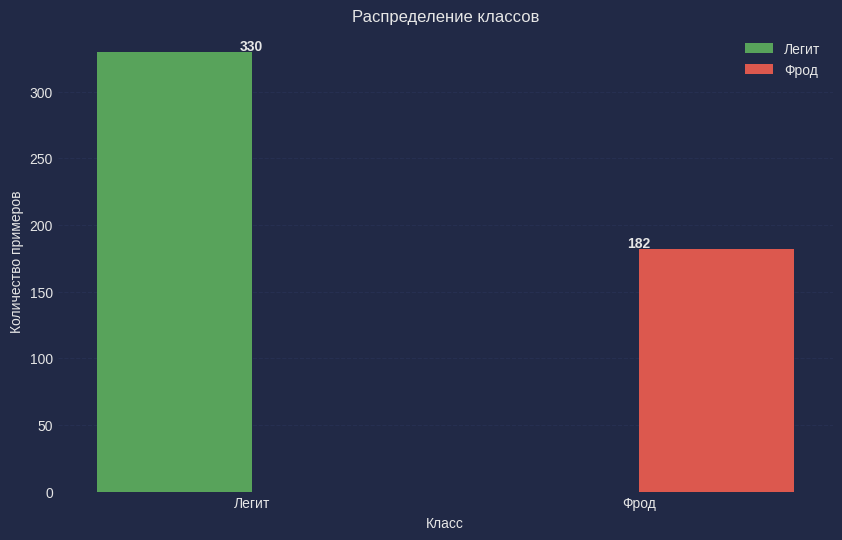

In [78]:
ea.plot_class_distribution(df)

##### Вывод:
- Распределение классов специально было сделано неравномерным, чтоб хотя бы чуть-чуть приблизить пропорцию к реальным данным.
- График частично по каким-то причинам слетел, хотя на kaggle отображался корректно.
- Нынешняя пропорцию классов составляет 2:1, в пользу легита (то есть пропорция легит:фрод).

In [80]:
df_len = ea.add_length_columns(df)

In [81]:
ea.describe_lengths(df_len)

,char_mean,char_median,char_p95,char_p99,word_mean,word_median,word_p95,word_p99
0,968.242188,256.0,4512.7,10446.37,149.880859,34.0,719.05,1670.12


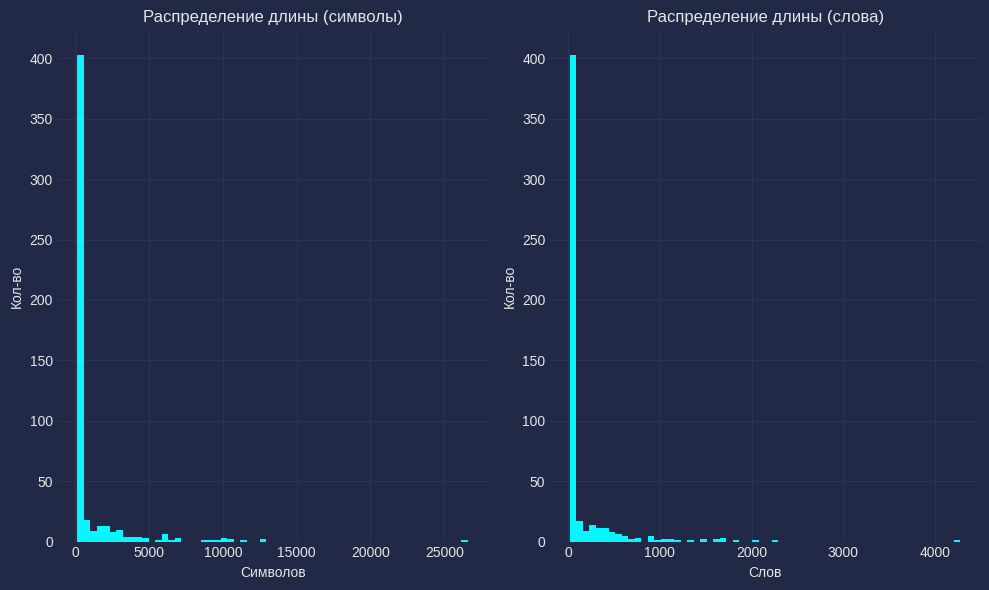

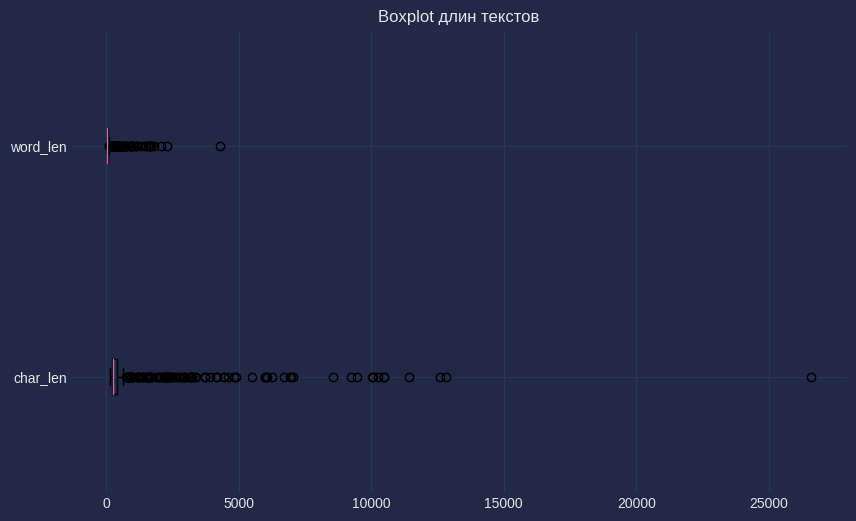

In [82]:
ea.plot_length_distributions(df_len)

In [83]:
ea.short_long_shares(df_len)

Доля коротких (<5 слов): 0.00%
Доля длинных (>500 слов): 7.81%


##### Вывод:

- Средняя длина текста приблизительно 968 символов (то есть где-то 150 слов), медиана значительно ниже (256 символов и 34 слова), что указывает на сильную асимметрию распределения.  
- Около 11.7% текстов превышают лимит 512 токенов, ~7.8% содержат более 500 слов.  
- Крайне коротких текстов (<5 слов) практически нет.  
- На графиках заметны выбросы до 25к символов и >4к слов, вероятно это шум (длинные расшифровки или спорные диалоги).  
- Основной массив данных укладывается в диапазон 128–512 токенов; тексты выше 512 скорее всего не добавляют пользы, поэтому разумно обрезать их.  
- Оптимальной является максимальная длина 384–512 токенов: этого достаточно для большинства текстов и при этом ресурсы используются эффективнее.  

In [85]:
flags = pp.scan_sensitive_flags(df)
print(flags.sum().sort_values(ascending=False))

has_any_sensitive       37
has_any_code_request    37
has_code_phrase         25
has_passport            16
has_phone               15
has_call_end            10
has_snils                3
has_forbidden            0
has_url                  0
has_email                0
has_bic                  0
has_cvv_pin_puk          0
has_card                 0
has_inn                  0
has_invisible            0
has_ks_rs_20d            0
has_dob                  0
has_any_payment_data     0
dtype: int64


##### Вывод по бинарным признакам наличия сущностей:

- Чаще всего встречаются признаки: наличие чувствительных данных (37 случаев), запросы кодов (37) и кодовые фразы (25).  
- Личные документы встречаются реже: паспорт (16), телефон (15), СНИЛС (3).  
- Завершающие признаки разговора (`has_call_end`) отмечены в 10 случаях.  
- Другие потенциально важные признаки (`has_url`, `has_email`, `has_card`, `has_inn`, `has_dob`, платёжные данные и др.) отсутствуют в текущем срезе.  
- Наблюдается выраженный дисбаланс по распределению признаков: часть встречается достаточно часто, а часть полностью отсутствует.  
- Для дальнейшего анализа и построения моделей требуется предобработка: очистка, нормализация, возможная агрегация редких признаков, а также балансировка.  

### Предобработка текста

#### Нормализация и замена на маски сущностей

In [86]:
df_clean = pp.apply_redaction(df)
pp.show_changes(df, df_clean, n=5)


До изменений:
 Здравствуйте, Альфа‑Банк. Предлагаем рефинансирование кредита с пониженной ставкой и без обязательной страховки. Интересно ли обсудить условия на коротком звонке. Пока не планирую. Понимаю, предложение останется в личном кабинете, если что — вернёмся к вопросу.
После изменений:
 Здравствуйте, Альфа-Банк. Предлагаем рефинансирование кредита с пониженной ставкой и без обязательной страховки. Интересно ли обсудить условия на коротком звонке. Пока не планирую. Понимаю, предложение останется в личном кабинете, если что - вернёмся к вопросу.

До изменений:
 Алло, оператор МТС, напоминаем о продлении периода обслуживания вашего номера, оформим сейчас? Спасибо, не надо. Это обязательная процедура, иначе исходящие могут быть ограничены. Не интересует, до свидания. Мы лишь информируем, потребуется код из сообщения. Удалите мой номер, ничего подтверждать не буду. Абонент завершил разговор.
После изменений:
 Алло, оператор МТС, напоминаем о продлении периода обслуживания вашего ном

In [87]:
pp.show_changes_random(df, df_clean, text_col="text", n=5, random_state=7)


До изменений:
 Алло, Билайн, добрый день. По вашему номеру активирован переход на eSIM, чтобы номер не ушёл в деактивацию, нужно подтвердить продление профиля. Это платно? Нет, бесплатно, просто откройте уведомление «Билайн — eSIM», там кнопка «Продлить» и одноразовый код. Вижу уведомление. Нажимайте, вводите код, затем отметьте номер основным, иначе исходящие могут временно отключиться на сутки.
После изменений:
 Алло, Билайн, добрый день. По вашему номеру активирован переход на eSIM, чтобы номер не ушёл в деактивацию, нужно подтвердить продление профиля. Это платно? Нет, бесплатно, просто откройте уведомление «Билайн - eSIM», там кнопка «Продлить» и [CODE_REQUEST]. Вижу уведомление. Нажимайте, [CODE_REQUEST], затем отметьте номер основным, иначе исходящие могут временно отключиться на сутки.

До изменений:
 Здравствуйте, Tele2. Появился пакет «Для работы» с увеличенным числом минут на городские номера и сохранением вашего интернет‑пакета. Интересно активировать на месяц. Да, подключ

In [88]:
flags_after = pp.scan_sensitive_flags(df_clean)
print(flags_after.sum().sort_values(ascending=False))

has_forbidden           0
has_url                 0
has_email               0
has_phone               0
has_passport            0
has_snils               0
has_card                0
has_code_phrase         0
has_cvv_pin_puk         0
has_bic                 0
has_inn                 0
has_ks_rs_20d           0
has_call_end            0
has_invisible           0
has_dob                 0
has_any_code_request    0
has_any_payment_data    0
has_any_sensitive       0
dtype: int64


##### Вывод по предобработке и маскам сущностей:

- В процессе работы проводилось несколько попыток исправить и корректно переписать маски сущностей ([PHONE], [CARD_PART], [CODE_REQUEST], [SNILS] и др.).  
- В итоговом варианте были найдены ошибки в расстановке или применении масок, здесь остаётся вопрос об их критичности — для анализа это может быть несущественно, но для обучения модели может влиять на результат, хотя таких примеров в датасете очень мало.  
- Отдельно стоит отметить, что предварительная предобработка текстов уже выполнялась ещё на этапе парсинга данных, однако здесь дополнительно проведена повторная очистка и нормализация.  
- Итоговая предобработка позволила унифицировать данные и подготовить их к дальнейшему использованию в пайплайне.  

### **Модель классификации**

#### Валидация и токенезация

In [92]:
LABEL_COL = "label"
TEST_SIZE = 0.10
N_SPLITS_DESIRED = 5
SEED_LOCKBOX = 42
SEED_FOLDS = 20

plan = mt.build_validation_plan(
    df_clean=df_clean,
    label_col=LABEL_COL,
    test_size=TEST_SIZE,
    n_splits_desired=N_SPLITS_DESIRED,
    seed_lockbox=SEED_LOCKBOX,
    seed_folds=SEED_FOLDS,
)

TEST_IDX = plan['TEST_IDX']
FOLDS_IDX = plan['FOLDS_IDX']
folds_report = plan['folds_report']

Размеры: train_pool=460 | test=52
Доля позитива: full=0.355 | train_pool=0.357 | test=0.346


,fold,valid_size,pos_valid,neg_valid,pos_rate_valid,pos_rate_delta_vs_pool
0,1.0,92.0,32.0,60.0,0.347826,-0.008696
1,2.0,92.0,33.0,59.0,0.358696,0.002174
2,3.0,92.0,33.0,59.0,0.358696,0.002174
3,4.0,92.0,33.0,59.0,0.358696,0.002174
4,5.0,92.0,33.0,59.0,0.358696,0.002174
summary,NaN,460.0,164.0,296.0,0.356522,NaN


Тестовая выборка (lockbox): 52 объектов
Фолдов: 5; пример размеров первого фолда — обучение 368, валидация 92
Проверки корректности разбиений пройдены


##### Вывод:

- Датасет разделён на `train_pool` (460 объектов) и тестовую выборку `lockbox` (52 объекта).  
- Доля положительных классов (позитивов) сбалансирована: во всём датасете — 0.355, в `train_pool` — 0.357, в `test` — 0.346.  
- Для валидации использовалась 5-фолдовая кросс-валидация с равномерным распределением позитивов и негативов:  
  - в каждом фолде 92 объекта валидации и 368 объектов обучения,  
  - доля позитивов на валидации колеблется в пределах 0.347–0.359, что практически совпадает с общей долей в `train_pool`.  
- Итоговая проверка показала, что разбиения корректны: классовый баланс сохранён, смещения относительно пула минимальны.  

Длиннее 384 токенов: 13.5% строк


count     512.000000
mean      196.792969
std       393.513010
min        31.000000
50%        53.500000
90%       548.000000
95%       987.850000
99%      2223.990000
max      2765.000000
Name: tok_len, dtype: float64

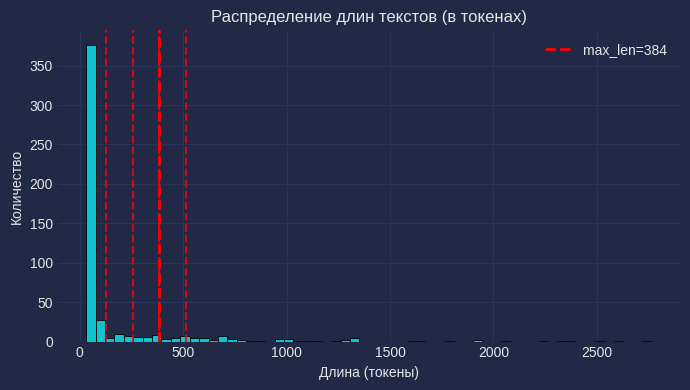

In [96]:
tokenizer = mt.build_tokenizer(base_cfg)

lengths = mt.compute_token_lengths(df_clean, tokenizer, base_cfg.text_col)
pct_long = (lengths > base_cfg.max_length).mean() * 100.0
print(f"Длиннее {base_cfg.max_length} токенов: {pct_long:.1f}% строк")
display(lengths.describe(percentiles=[.5, .9, .95, .99]))

mt.plot_token_length_hist(lengths, base_cfg.max_length)

##### Вывод по распределению длин текстов:

- Средняя длина текста составила примерно 197 токенов, медиана — 54 токена.  
- 90% текстов имеют длину примерно до 548 токенов, 95% — до примерно 988, а 99% — до примерно 2224 токенов.  
- Максимальная длина в выборке — 2765 токенов.  
- При ограничении `max_len=384` обрезается где-то 13.5% строк, то есть подавляющее большинство текстов укладывается в заданное ограничение.  
- Гистограмма показывает, что основная масса текстов имеет небольшую длину (примерно до 200 токенов), длинные тексты встречаются редко и являются выбросами.  
- Выбранное значение `max_len=384` является компромиссом: оно позволяет сохранить все ключевые данные, одновременно снижая нагрузку на память и ускоряя обучение модели.  

#### Обучение с кросс валидацией (KFold = 5)

In [104]:
print("Старт кросс-валидации базовой конфигурации")
cv_res = mt.train_cv(df_clean, FOLDS_IDX, base_cfg)

thr_res = mt.choose_thresholds_and_report(
    cv_res['oof_logits'], cv_res['of_mask'], df_clean[base_cfg.label_col].to_numpy(), base_cfg
)
chosen_thr = thr_res['thr_precision']
print(f"Выбран порог по требуемой точности: {chosen_thr:.4f}")

Старт кросс-валидации базовой конфигурации
Старт кросс-валидации базовой конфигурации
Фолд 1: обучение на 368, валидация на 92


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased-conversational and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Используется LoRA (SEQ_CLS)
Используется BCEWithLogitsLoss с pos_weight=1.788


Эпоха 1/4 — обучение:   0%|          | 0/23 [00:00<?, ?it/s]

Оценка на валидации:   0%|          | 0/6 [00:00<?, ?it/s]

Эпоха 1: средний loss=0.8765, PR-AUC валид=0.7562


Эпоха 2/4 — обучение:   0%|          | 0/23 [00:00<?, ?it/s]

Оценка на валидации:   0%|          | 0/6 [00:00<?, ?it/s]

Эпоха 2: средний loss=0.8682, PR-AUC валид=0.7790


Эпоха 3/4 — обучение:   0%|          | 0/23 [00:00<?, ?it/s]

Оценка на валидации:   0%|          | 0/6 [00:00<?, ?it/s]

Эпоха 3: средний loss=0.8748, PR-AUC валид=0.7935


Эпоха 4/4 — обучение:   0%|          | 0/23 [00:00<?, ?it/s]

Оценка на валидации:   0%|          | 0/6 [00:00<?, ?it/s]

Эпоха 4: средний loss=0.8726, PR-AUC валид=0.7872
Фолд 1: лучший PR-AUC валид = 0.7935
Фолд 2: обучение на 368, валидация на 92


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased-conversational and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Используется LoRA (SEQ_CLS)
Используется BCEWithLogitsLoss с pos_weight=1.809


Эпоха 1/4 — обучение:   0%|          | 0/23 [00:00<?, ?it/s]

Оценка на валидации:   0%|          | 0/6 [00:00<?, ?it/s]

Эпоха 1: средний loss=0.8845, PR-AUC валид=0.8582


Эпоха 2/4 — обучение:   0%|          | 0/23 [00:00<?, ?it/s]

Оценка на валидации:   0%|          | 0/6 [00:00<?, ?it/s]

Эпоха 2: средний loss=0.8816, PR-AUC валид=0.8732


Эпоха 3/4 — обучение:   0%|          | 0/23 [00:00<?, ?it/s]

Оценка на валидации:   0%|          | 0/6 [00:00<?, ?it/s]

Эпоха 3: средний loss=0.8743, PR-AUC валид=0.8784


Эпоха 4/4 — обучение:   0%|          | 0/23 [00:00<?, ?it/s]

Оценка на валидации:   0%|          | 0/6 [00:00<?, ?it/s]

Эпоха 4: средний loss=0.8678, PR-AUC валид=0.8796
Фолд 2: лучший PR-AUC валид = 0.8796
Фолд 3: обучение на 368, валидация на 92


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased-conversational and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Используется LoRA (SEQ_CLS)
Используется BCEWithLogitsLoss с pos_weight=1.809


Эпоха 1/4 — обучение:   0%|          | 0/23 [00:00<?, ?it/s]

Оценка на валидации:   0%|          | 0/6 [00:00<?, ?it/s]

Эпоха 1: средний loss=0.8789, PR-AUC валид=0.8024


Эпоха 2/4 — обучение:   0%|          | 0/23 [00:00<?, ?it/s]

Оценка на валидации:   0%|          | 0/6 [00:00<?, ?it/s]

Эпоха 2: средний loss=0.8769, PR-AUC валид=0.8255


Эпоха 3/4 — обучение:   0%|          | 0/23 [00:00<?, ?it/s]

Оценка на валидации:   0%|          | 0/6 [00:00<?, ?it/s]

Эпоха 3: средний loss=0.8749, PR-AUC валид=0.8487


Эпоха 4/4 — обучение:   0%|          | 0/23 [00:00<?, ?it/s]

Оценка на валидации:   0%|          | 0/6 [00:00<?, ?it/s]

Эпоха 4: средний loss=0.8784, PR-AUC валид=0.8518
Фолд 3: лучший PR-AUC валид = 0.8518
Фолд 4: обучение на 368, валидация на 92


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased-conversational and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Используется LoRA (SEQ_CLS)
Используется BCEWithLogitsLoss с pos_weight=1.809


Эпоха 1/4 — обучение:   0%|          | 0/23 [00:00<?, ?it/s]

Оценка на валидации:   0%|          | 0/6 [00:00<?, ?it/s]

Эпоха 1: средний loss=0.8774, PR-AUC валид=0.8279


Эпоха 2/4 — обучение:   0%|          | 0/23 [00:00<?, ?it/s]

Оценка на валидации:   0%|          | 0/6 [00:00<?, ?it/s]

Эпоха 2: средний loss=0.8790, PR-AUC валид=0.8476


Эпоха 3/4 — обучение:   0%|          | 0/23 [00:00<?, ?it/s]

Оценка на валидации:   0%|          | 0/6 [00:00<?, ?it/s]

Эпоха 3: средний loss=0.8725, PR-AUC валид=0.8560


Эпоха 4/4 — обучение:   0%|          | 0/23 [00:00<?, ?it/s]

Оценка на валидации:   0%|          | 0/6 [00:00<?, ?it/s]

Эпоха 4: средний loss=0.8746, PR-AUC валид=0.8630
Фолд 4: лучший PR-AUC валид = 0.8630
Фолд 5: обучение на 368, валидация на 92


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased-conversational and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Используется LoRA (SEQ_CLS)
Используется BCEWithLogitsLoss с pos_weight=1.809


Эпоха 1/4 — обучение:   0%|          | 0/23 [00:00<?, ?it/s]

Оценка на валидации:   0%|          | 0/6 [00:00<?, ?it/s]

Эпоха 1: средний loss=0.8831, PR-AUC валид=0.8844


Эпоха 2/4 — обучение:   0%|          | 0/23 [00:00<?, ?it/s]

Оценка на валидации:   0%|          | 0/6 [00:00<?, ?it/s]

Эпоха 2: средний loss=0.8749, PR-AUC валид=0.8864


Эпоха 3/4 — обучение:   0%|          | 0/23 [00:00<?, ?it/s]

Оценка на валидации:   0%|          | 0/6 [00:00<?, ?it/s]

Эпоха 3: средний loss=0.8745, PR-AUC валид=0.8930


Эпоха 4/4 — обучение:   0%|          | 0/23 [00:00<?, ?it/s]

Оценка на валидации:   0%|          | 0/6 [00:00<?, ?it/s]

Эпоха 4: средний loss=0.8761, PR-AUC валид=0.8927
Фолд 5: лучший PR-AUC валид = 0.8930
Сводка по фолдам:


,fold,valid_size,pr_auc,precision@0.5,recall@0.5,f1@0.5
0,1,92,0.787160,1.000000,0.437500,0.608696
1,2,92,0.879584,1.000000,0.484848,0.653061
2,3,92,0.851819,1.000000,0.272727,0.428571
3,4,92,0.863046,1.000000,0.393939,0.565217
4,5,92,0.892725,0.894737,0.515152,0.653846


OOF PR-AUC по всем фолдам: 0.8424
Порог по максимуму F1:
{'threshold': 0.49174743125194204, 'precision': 0.7662337662337663, 'recall': 0.7195121951219512, 'f1': 0.7421383647798743, 'pr_auc': 0.8424116334679523, 'brier': 0.2397358089025973, 'confusion_matrix': [[260, 36], [46, 118]]}
Порог по требуемой точности:
{'threshold': 0.49607084770341703, 'precision': 0.9042553191489362, 'recall': 0.5182926829268293, 'f1': 0.6589147286821705, 'pr_auc': 0.8424116334679523, 'brier': 0.2397358089025973, 'confusion_matrix': [[287, 9], [79, 85]]}
Выбран порог по требуемой точности: 0.4961


In [105]:
print("Запуск оптимизации гиперпараметров")
hpo = mt.hpo_search(df_clean, FOLDS_IDX, base_cfg, n_trials=3)

best_cfg = hpo['best']['config']
best_cv_res = hpo['best']['result']

best_thr_res = mt.choose_thresholds_and_report(
    best_cv_res['oof_logits'], best_cv_res['oof_mask'],
    df_clean[best_cfg.label_col].to_numpy(), best_cfg
)
best_thr = best_thr_res['thr_precision']
print(f"Выбран порог по лучшей конфигурации: {best_thr:.4f}")

Запуск оптимизации гиперпараметров
Запуск подбора №1/3
Старт кросс-валидации базовой конфигурации
Фолд 1: обучение на 368, валидация на 92


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased-conversational and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Используется LoRA (SEQ_CLS)
Используется BCEWithLogitsLoss с pos_weight=1.788


Эпоха 1/3 — обучение:   0%|          | 0/23 [00:00<?, ?it/s]

Оценка на валидации:   0%|          | 0/6 [00:00<?, ?it/s]

Эпоха 1: средний loss=0.8700, PR-AUC валид=0.7748


Эпоха 2/3 — обучение:   0%|          | 0/23 [00:00<?, ?it/s]

Оценка на валидации:   0%|          | 0/6 [00:00<?, ?it/s]

Эпоха 2: средний loss=0.8667, PR-AUC валид=0.7428


Эпоха 3/3 — обучение:   0%|          | 0/23 [00:00<?, ?it/s]

Оценка на валидации:   0%|          | 0/6 [00:00<?, ?it/s]

Эпоха 3: средний loss=0.8603, PR-AUC валид=0.7508
Фолд 1: лучший PR-AUC валид = 0.7748
Фолд 2: обучение на 368, валидация на 92


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased-conversational and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Используется LoRA (SEQ_CLS)
Используется BCEWithLogitsLoss с pos_weight=1.809


Эпоха 1/3 — обучение:   0%|          | 0/23 [00:00<?, ?it/s]

Оценка на валидации:   0%|          | 0/6 [00:00<?, ?it/s]

Эпоха 1: средний loss=0.8721, PR-AUC валид=0.8769


Эпоха 2/3 — обучение:   0%|          | 0/23 [00:00<?, ?it/s]

Оценка на валидации:   0%|          | 0/6 [00:00<?, ?it/s]

Эпоха 2: средний loss=0.8757, PR-AUC валид=0.8859


Эпоха 3/3 — обучение:   0%|          | 0/23 [00:00<?, ?it/s]

Оценка на валидации:   0%|          | 0/6 [00:00<?, ?it/s]

Эпоха 3: средний loss=0.8695, PR-AUC валид=0.8864
Фолд 2: лучший PR-AUC валид = 0.8864
Фолд 3: обучение на 368, валидация на 92


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased-conversational and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Используется LoRA (SEQ_CLS)
Используется BCEWithLogitsLoss с pos_weight=1.809


Эпоха 1/3 — обучение:   0%|          | 0/23 [00:00<?, ?it/s]

Оценка на валидации:   0%|          | 0/6 [00:00<?, ?it/s]

Эпоха 1: средний loss=0.8823, PR-AUC валид=0.8406


Эпоха 2/3 — обучение:   0%|          | 0/23 [00:00<?, ?it/s]

Оценка на валидации:   0%|          | 0/6 [00:00<?, ?it/s]

Эпоха 2: средний loss=0.8716, PR-AUC валид=0.8729


Эпоха 3/3 — обучение:   0%|          | 0/23 [00:00<?, ?it/s]

Оценка на валидации:   0%|          | 0/6 [00:00<?, ?it/s]

Эпоха 3: средний loss=0.8696, PR-AUC валид=0.8782
Фолд 3: лучший PR-AUC валид = 0.8782
Фолд 4: обучение на 368, валидация на 92


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased-conversational and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Используется LoRA (SEQ_CLS)
Используется BCEWithLogitsLoss с pos_weight=1.809


Эпоха 1/3 — обучение:   0%|          | 0/23 [00:00<?, ?it/s]

Оценка на валидации:   0%|          | 0/6 [00:00<?, ?it/s]

Эпоха 1: средний loss=0.8774, PR-AUC валид=0.8664


Эпоха 2/3 — обучение:   0%|          | 0/23 [00:00<?, ?it/s]

Оценка на валидации:   0%|          | 0/6 [00:00<?, ?it/s]

Эпоха 2: средний loss=0.8779, PR-AUC валид=0.8995


Эпоха 3/3 — обучение:   0%|          | 0/23 [00:00<?, ?it/s]

Оценка на валидации:   0%|          | 0/6 [00:00<?, ?it/s]

Эпоха 3: средний loss=0.8739, PR-AUC валид=0.8879
Фолд 4: лучший PR-AUC валид = 0.8995
Фолд 5: обучение на 368, валидация на 92


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased-conversational and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Используется LoRA (SEQ_CLS)
Используется BCEWithLogitsLoss с pos_weight=1.809


Эпоха 1/3 — обучение:   0%|          | 0/23 [00:00<?, ?it/s]

Оценка на валидации:   0%|          | 0/6 [00:00<?, ?it/s]

Эпоха 1: средний loss=0.8792, PR-AUC валид=0.8624


Эпоха 2/3 — обучение:   0%|          | 0/23 [00:00<?, ?it/s]

Оценка на валидации:   0%|          | 0/6 [00:00<?, ?it/s]

Эпоха 2: средний loss=0.8718, PR-AUC валид=0.8637


Эпоха 3/3 — обучение:   0%|          | 0/23 [00:00<?, ?it/s]

Оценка на валидации:   0%|          | 0/6 [00:00<?, ?it/s]

Эпоха 3: средний loss=0.8712, PR-AUC валид=0.8591
Фолд 5: лучший PR-AUC валид = 0.8637
Сводка по фолдам:


,fold,valid_size,pr_auc,precision@0.5,recall@0.5,f1@0.5
0,1,92,0.750836,0.933333,0.437500,0.595745
1,2,92,0.886413,1.000000,0.454545,0.625000
2,3,92,0.878245,1.000000,0.424242,0.595745
3,4,92,0.887851,1.000000,0.393939,0.565217
4,5,92,0.859117,0.814815,0.666667,0.733333


OOF PR-AUC по всем фолдам: 0.8185
Оценка OOF PR-AUC: 0.8185
Запуск подбора №2/3
Старт кросс-валидации базовой конфигурации
Фолд 1: обучение на 368, валидация на 92


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased-conversational and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Используется LoRA (SEQ_CLS)
Используется BCEWithLogitsLoss с pos_weight=1.788


Эпоха 1/3 — обучение:   0%|          | 0/23 [00:00<?, ?it/s]

Оценка на валидации:   0%|          | 0/6 [00:00<?, ?it/s]

Эпоха 1: средний loss=0.8700, PR-AUC валид=0.7748


Эпоха 2/3 — обучение:   0%|          | 0/23 [00:00<?, ?it/s]

Оценка на валидации:   0%|          | 0/6 [00:00<?, ?it/s]

Эпоха 2: средний loss=0.8667, PR-AUC валид=0.7428


Эпоха 3/3 — обучение:   0%|          | 0/23 [00:00<?, ?it/s]

Оценка на валидации:   0%|          | 0/6 [00:00<?, ?it/s]

Эпоха 3: средний loss=0.8603, PR-AUC валид=0.7508
Фолд 1: лучший PR-AUC валид = 0.7748
Фолд 2: обучение на 368, валидация на 92


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased-conversational and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Используется LoRA (SEQ_CLS)
Используется BCEWithLogitsLoss с pos_weight=1.809


Эпоха 1/3 — обучение:   0%|          | 0/23 [00:00<?, ?it/s]

Оценка на валидации:   0%|          | 0/6 [00:00<?, ?it/s]

Эпоха 1: средний loss=0.8721, PR-AUC валид=0.8769


Эпоха 2/3 — обучение:   0%|          | 0/23 [00:00<?, ?it/s]

Оценка на валидации:   0%|          | 0/6 [00:00<?, ?it/s]

Эпоха 2: средний loss=0.8757, PR-AUC валид=0.8859


Эпоха 3/3 — обучение:   0%|          | 0/23 [00:00<?, ?it/s]

Оценка на валидации:   0%|          | 0/6 [00:00<?, ?it/s]

Эпоха 3: средний loss=0.8695, PR-AUC валид=0.8864
Фолд 2: лучший PR-AUC валид = 0.8864
Фолд 3: обучение на 368, валидация на 92


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased-conversational and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Используется LoRA (SEQ_CLS)
Используется BCEWithLogitsLoss с pos_weight=1.809


Эпоха 1/3 — обучение:   0%|          | 0/23 [00:00<?, ?it/s]

Оценка на валидации:   0%|          | 0/6 [00:00<?, ?it/s]

Эпоха 1: средний loss=0.8823, PR-AUC валид=0.8406


Эпоха 2/3 — обучение:   0%|          | 0/23 [00:00<?, ?it/s]

Оценка на валидации:   0%|          | 0/6 [00:00<?, ?it/s]

Эпоха 2: средний loss=0.8716, PR-AUC валид=0.8729


Эпоха 3/3 — обучение:   0%|          | 0/23 [00:00<?, ?it/s]

Оценка на валидации:   0%|          | 0/6 [00:00<?, ?it/s]

Эпоха 3: средний loss=0.8696, PR-AUC валид=0.8782
Фолд 3: лучший PR-AUC валид = 0.8782
Фолд 4: обучение на 368, валидация на 92


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased-conversational and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Используется LoRA (SEQ_CLS)
Используется BCEWithLogitsLoss с pos_weight=1.809


Эпоха 1/3 — обучение:   0%|          | 0/23 [00:00<?, ?it/s]

Оценка на валидации:   0%|          | 0/6 [00:00<?, ?it/s]

Эпоха 1: средний loss=0.8774, PR-AUC валид=0.8664


Эпоха 2/3 — обучение:   0%|          | 0/23 [00:00<?, ?it/s]

Оценка на валидации:   0%|          | 0/6 [00:00<?, ?it/s]

Эпоха 2: средний loss=0.8779, PR-AUC валид=0.8995


Эпоха 3/3 — обучение:   0%|          | 0/23 [00:00<?, ?it/s]

Оценка на валидации:   0%|          | 0/6 [00:00<?, ?it/s]

Эпоха 3: средний loss=0.8739, PR-AUC валид=0.8879
Фолд 4: лучший PR-AUC валид = 0.8995
Фолд 5: обучение на 368, валидация на 92


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased-conversational and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Используется LoRA (SEQ_CLS)
Используется BCEWithLogitsLoss с pos_weight=1.809


Эпоха 1/3 — обучение:   0%|          | 0/23 [00:00<?, ?it/s]

Оценка на валидации:   0%|          | 0/6 [00:00<?, ?it/s]

Эпоха 1: средний loss=0.8792, PR-AUC валид=0.8624


Эпоха 2/3 — обучение:   0%|          | 0/23 [00:00<?, ?it/s]

Оценка на валидации:   0%|          | 0/6 [00:00<?, ?it/s]

Эпоха 2: средний loss=0.8718, PR-AUC валид=0.8637


Эпоха 3/3 — обучение:   0%|          | 0/23 [00:00<?, ?it/s]

Оценка на валидации:   0%|          | 0/6 [00:00<?, ?it/s]

Эпоха 3: средний loss=0.8712, PR-AUC валид=0.8591
Фолд 5: лучший PR-AUC валид = 0.8637
Сводка по фолдам:


,fold,valid_size,pr_auc,precision@0.5,recall@0.5,f1@0.5
0,1,92,0.750836,0.933333,0.437500,0.595745
1,2,92,0.886413,1.000000,0.454545,0.625000
2,3,92,0.878245,1.000000,0.424242,0.595745
3,4,92,0.887851,1.000000,0.393939,0.565217
4,5,92,0.859117,0.814815,0.666667,0.733333


OOF PR-AUC по всем фолдам: 0.8185
Оценка OOF PR-AUC: 0.8185
Запуск подбора №3/3
Старт кросс-валидации базовой конфигурации
Фолд 1: обучение на 368, валидация на 92


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased-conversational and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Используется LoRA (SEQ_CLS)
Используется BCEWithLogitsLoss с pos_weight=1.788


Эпоха 1/3 — обучение:   0%|          | 0/23 [00:00<?, ?it/s]

Оценка на валидации:   0%|          | 0/6 [00:00<?, ?it/s]

Эпоха 1: средний loss=0.8700, PR-AUC валид=0.7748


Эпоха 2/3 — обучение:   0%|          | 0/23 [00:00<?, ?it/s]

Оценка на валидации:   0%|          | 0/6 [00:00<?, ?it/s]

Эпоха 2: средний loss=0.8667, PR-AUC валид=0.7428


Эпоха 3/3 — обучение:   0%|          | 0/23 [00:00<?, ?it/s]

Оценка на валидации:   0%|          | 0/6 [00:00<?, ?it/s]

Эпоха 3: средний loss=0.8603, PR-AUC валид=0.7508
Фолд 1: лучший PR-AUC валид = 0.7748
Фолд 2: обучение на 368, валидация на 92


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased-conversational and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Используется LoRA (SEQ_CLS)
Используется BCEWithLogitsLoss с pos_weight=1.809


Эпоха 1/3 — обучение:   0%|          | 0/23 [00:00<?, ?it/s]

Оценка на валидации:   0%|          | 0/6 [00:00<?, ?it/s]

Эпоха 1: средний loss=0.8721, PR-AUC валид=0.8769


Эпоха 2/3 — обучение:   0%|          | 0/23 [00:00<?, ?it/s]

Оценка на валидации:   0%|          | 0/6 [00:00<?, ?it/s]

Эпоха 2: средний loss=0.8757, PR-AUC валид=0.8859


Эпоха 3/3 — обучение:   0%|          | 0/23 [00:00<?, ?it/s]

Оценка на валидации:   0%|          | 0/6 [00:00<?, ?it/s]

Эпоха 3: средний loss=0.8695, PR-AUC валид=0.8864
Фолд 2: лучший PR-AUC валид = 0.8864
Фолд 3: обучение на 368, валидация на 92


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased-conversational and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Используется LoRA (SEQ_CLS)
Используется BCEWithLogitsLoss с pos_weight=1.809


Эпоха 1/3 — обучение:   0%|          | 0/23 [00:00<?, ?it/s]

Оценка на валидации:   0%|          | 0/6 [00:00<?, ?it/s]

Эпоха 1: средний loss=0.8823, PR-AUC валид=0.8406


Эпоха 2/3 — обучение:   0%|          | 0/23 [00:00<?, ?it/s]

Оценка на валидации:   0%|          | 0/6 [00:00<?, ?it/s]

Эпоха 2: средний loss=0.8716, PR-AUC валид=0.8729


Эпоха 3/3 — обучение:   0%|          | 0/23 [00:00<?, ?it/s]

Оценка на валидации:   0%|          | 0/6 [00:00<?, ?it/s]

Эпоха 3: средний loss=0.8696, PR-AUC валид=0.8782
Фолд 3: лучший PR-AUC валид = 0.8782
Фолд 4: обучение на 368, валидация на 92


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased-conversational and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Используется LoRA (SEQ_CLS)
Используется BCEWithLogitsLoss с pos_weight=1.809


Эпоха 1/3 — обучение:   0%|          | 0/23 [00:00<?, ?it/s]

Оценка на валидации:   0%|          | 0/6 [00:00<?, ?it/s]

Эпоха 1: средний loss=0.8774, PR-AUC валид=0.8664


Эпоха 2/3 — обучение:   0%|          | 0/23 [00:00<?, ?it/s]

Оценка на валидации:   0%|          | 0/6 [00:00<?, ?it/s]

Эпоха 2: средний loss=0.8779, PR-AUC валид=0.8995


Эпоха 3/3 — обучение:   0%|          | 0/23 [00:00<?, ?it/s]

Оценка на валидации:   0%|          | 0/6 [00:00<?, ?it/s]

Эпоха 3: средний loss=0.8739, PR-AUC валид=0.8879
Фолд 4: лучший PR-AUC валид = 0.8995
Фолд 5: обучение на 368, валидация на 92


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased-conversational and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Используется LoRA (SEQ_CLS)
Используется BCEWithLogitsLoss с pos_weight=1.809


Эпоха 1/3 — обучение:   0%|          | 0/23 [00:00<?, ?it/s]

Оценка на валидации:   0%|          | 0/6 [00:00<?, ?it/s]

Эпоха 1: средний loss=0.8792, PR-AUC валид=0.8624


Эпоха 2/3 — обучение:   0%|          | 0/23 [00:00<?, ?it/s]

Оценка на валидации:   0%|          | 0/6 [00:00<?, ?it/s]

Эпоха 2: средний loss=0.8718, PR-AUC валид=0.8637


Эпоха 3/3 — обучение:   0%|          | 0/23 [00:00<?, ?it/s]

Оценка на валидации:   0%|          | 0/6 [00:00<?, ?it/s]

Эпоха 3: средний loss=0.8712, PR-AUC валид=0.8591
Фолд 5: лучший PR-AUC валид = 0.8637
Сводка по фолдам:


,fold,valid_size,pr_auc,precision@0.5,recall@0.5,f1@0.5
0,1,92,0.750836,0.933333,0.437500,0.595745
1,2,92,0.886413,1.000000,0.454545,0.625000
2,3,92,0.878245,1.000000,0.424242,0.595745
3,4,92,0.887851,1.000000,0.393939,0.565217
4,5,92,0.859117,0.814815,0.666667,0.733333


OOF PR-AUC по всем фолдам: 0.8185
Оценка OOF PR-AUC: 0.8185
Лидборд гиперпараметров:


,trial,oof_pr_auc,model_name,text_col,label_col,max_length,batch_size,epochs,lr,weight_decay,warmup_prop,dropout,grad_clip_norm,use_amp,use_lora,lora_r,lora_alpha,lora_dropout,loss_type,focal_gamma,focal_alpha,target_precision,device,seed,num_workers,pin_memory,persistent_workers,prefetch_factor
0,1,0.818503,DeepPavlov/rubert-base-cased-conversational,text,label,384,16,3,0.00005,0.01,0.1,0.1,1.0,True,True,16,16,0.1,bce,2.0,0.25,0.9,cuda,42,0,True,False,None
1,2,0.818503,DeepPavlov/rubert-base-cased-conversational,text,label,384,16,3,0.00005,0.01,0.1,0.1,1.0,True,True,16,16,0.1,bce,2.0,0.25,0.9,cuda,42,0,True,False,None
2,3,0.818503,DeepPavlov/rubert-base-cased-conversational,text,label,384,16,3,0.00005,0.01,0.1,0.1,1.0,True,True,16,16,0.1,bce,2.0,0.25,0.9,cuda,42,0,True,False,None


Лучшая конфигурация: OOF PR-AUC=0.8185
Порог по максимуму F1:
{'threshold': 0.49050694056087046, 'precision': 0.6949152542372882, 'recall': 0.75, 'f1': 0.7214076246334312, 'pr_auc': 0.8185033477475125, 'brier': 0.23838648714308033, 'confusion_matrix': [[242, 54], [41, 123]]}
Порог по требуемой точности:
{'threshold': 0.4985759700734752, 'precision': 0.9021739130434783, 'recall': 0.5060975609756098, 'f1': 0.6484375, 'pr_auc': 0.8185033477475125, 'brier': 0.23838648714308033, 'confusion_matrix': [[287, 9], [81, 83]]}
Выбран порог по лучшей конфигурации: 0.4986


In [106]:
print("Финальное обучение на 90% и оценка на lockbox-тесте (лучшая конфигурация)")
final_res = mt.train_full_and_eval(df_clean, FOLDS_IDX, TEST_IDX, best_cfg, best_thr)

Финальное обучение на 90% и оценка на lockbox-тесте (лучшая конфигурация)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased-conversational and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Используется LoRA (SEQ_CLS)
Используется BCEWithLogitsLoss с pos_weight=1.805


Эпоха 1/3 — обучение на всех 90%:   0%|          | 0/29 [00:00<?, ?it/s]

Эпоха 1: средний loss=0.8907


Эпоха 2/3 — обучение на всех 90%:   0%|          | 0/29 [00:00<?, ?it/s]

Эпоха 2: средний loss=0.8841


Эпоха 3/3 — обучение на всех 90%:   0%|          | 0/29 [00:00<?, ?it/s]

Эпоха 3: средний loss=0.8780


Инференс на lockbox-тесте:   0%|          | 0/4 [00:00<?, ?it/s]

Итоговая оценка на lockbox-тесте:
{'threshold': 0.4985759700734752, 'precision': 0.8333333333333334, 'recall': 0.5555555555555556, 'f1': 0.6666666666666667, 'pr_auc': 0.8194044210028866, 'brier': 0.2420769590317935, 'confusion_matrix': [[32, 2], [8, 10]]}


##### Вывод по обучению

- В ходе экспериментов использовались две архитектуры: `sberbank-ai/ruRoberta-large` и `DeepPavlov/rubert-base-cased-conversational`.  
- Длинная модель от Сбера показывала более высокую метрику PR-AUC (около 0.91 на lockbox-тесте даже без оптимизации порога), однако при запуске на Kaggle ноутбук стабильно падал из-за переполнения RAM и необходимости хранить все веса. Проблема была не в самой модели, а в ограничениях вычислительной среды.  
- В итоге для финальной версии была выбрана более лёгкая модель `DeepPavlov/rubert-base-cased-conversational`, так как она позволила пройти полный пайплайн обучения, оптимизации гиперпараметров и финальной оценки без доработок, а времени уже не хватало, хотя я понял проблему.
    - Если подробнее про проблему, то она была в RAM, как я понял, ибо веса моделей сохранялись на каждом фолде, что под конец оптимизации порога говорило пока, ну и Kaggle пренудительно выключал/перезапускал ядро.
- Оптимизация гиперпараметров дала устойчивую OOF PR-AUC ≈ 0.8185. На lockbox-тесте итоговый результат составил PR-AUC ≈ 0.819, Precision = 0.83, Recall = 0.56, F1 = 0.67, Brier Score ≈ 0.242.  
- Таким образом, итоговый выбор в пользу более компактной модели был обусловлен ограничением по ресурсам и временем на исправление падений, при этом итоговая метрика осталась сопоставимой и стабильной в разных разбиениях. 

#### Проверка модели

In [108]:
scores_df = mt.assemble_full_scores(
    df_clean, cv_res, final_res, TEST_IDX, label_col=best_cfg.label_col
)

print("Сводка по источнику скоринга:")
print(scores_df["where"].value_counts(dropna=False))
print("\nЗаполнено вероятностями:", scores_df['score'].notna().sum(), "из", len(scores_df))

Сводка по источнику скоринга:
where
oof     460
test     52
Name: count, dtype: int64

Заполнено вероятностями: 512 из 512


##### Вывод:

- Всего объектов: 512 (460 в обучающем пуле, 52 в тестовом).
- Все 512 объектов успешно получили вероятностные предсказания (oof + test).

Отчёт на lockbox-тесте:
{'threshold': 0.4985759700734752, 'precision': 0.8333333333333334, 'recall': 0.5555555555555556, 'f1': 0.6666666666666667, 'pr_auc': 0.8194044210028866, 'brier': 0.2420769590317935, 'confusion_matrix': [[32, 2], [8, 10]]}


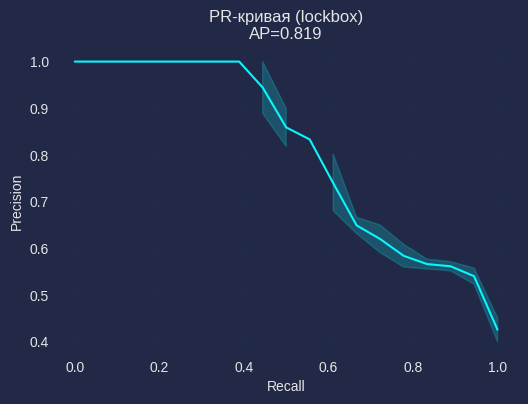

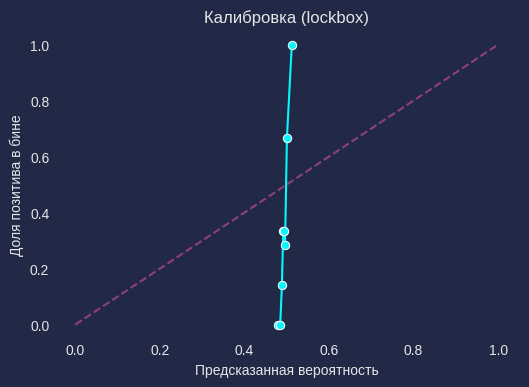

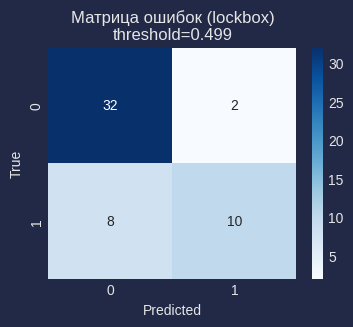

In [110]:
# Отчёт и графики на lockbox-тесте
mask_test = scores_df['where'].values == "test"
y_test = scores_df.loc[mask_test, 'y_true'].to_numpy()
s_test = scores_df.loc[mask_test, 'score'].to_numpy()

rep_test = mt.test_report(y_test, s_test, thr=best_thr)
print("Отчёт на lockbox-тесте:")
print(rep_test)

mt.plot_pr_curve(y_test, s_test, title="PR-кривая (lockbox)")
mt.plot_calibration(y_test, s_test, n_bins=8, title="Калибровка (lockbox)")
mt.plot_confmat(y_test, s_test, thr=best_thr, title="Матрица ошибок (lockbox)")

##### Отчёт на lockbox-тесте

- Выбранный порог: 0.499.
- Precision: 0.83 — высокая точность, большинство предсказанных положительных действительно являются таковыми.
- Recall: 0.56 — модель находит чуть больше половины реальных положительных примеров.
- F1-мера: 0.67 — сбалансированный показатель, подтверждает компромисс между precision и recall.
- PR-AUC: 0.82 — качество модели по основной метрике остаётся на хорошем уровне.
- Brier-скор: 0.24 — указывает на определённый зазор в калибровке вероятностей, однако значения находятся в допустимых пределах.
- Матрица ошибок: 32 TN, 2 FP, 8 FN, 10 TP — модель хорошо справляется с отрицательным классом, но иногда упускает позитивные примеры.

### **Кластеризация**

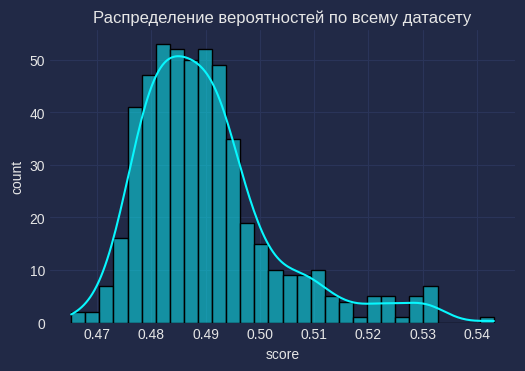

Кандидатов для кластеризации: 200


,text
0,Алло алло Арва телефону а вы кто министр образования учебного заведения А ну сейчас передам ва иди сюда Алло алло привет Да здравствуйте здравствуйте входила на уч Вась убу ну я же на больничном так смотри Варечка нам нужно посмотреть все твои твои пропуски я могу сейчас указать этот номер телефона как основной телефон Ну да Отлично Так о по пожалуйста А что у тебя что-то болит или теб заболела Ну я тебя что-то болит или теб заболела Ну я тебя что-то болит или теб заболела Ну я заболела Я же предупреждала Ага так смотри Варечка я сейчас захожу на твою зачётную книжечку чтоб посмотреть противо пропуском и указать в компьютере в в системе так одну минуточку так смотри Мар тебе сейчас придёт подтверждение на номер телефона смотри посмотри его Сохрани потому что это будет твой основной номер вода за учётную книжку ты должна его сохранить и мне указать чтобы я указала системе вода А куда придёт в контакт в СМС обычно сообщение уже должн прийти А кто отправитель Не что-то нет пока от госб отправитель Не что-то нет пока от госб отправитель Не что-то нет пока от госб должна была прийти госуслуги Да уче должно быть либо три цифры либо четыре Я просто не помню тут написано только мошенники спрашивают код А вы откуда Звоните мне вообще Министерство образования Я думала вы со школы р образования там где ты учишься Ну я думала со школы а а Министерство Почему мне звонит для того чтобы указать все твои пропуски Сколько у тебя было пропусков сечас всех увести передать выше Ну а я же учительниц передала всё почему-то всё почему-то всё почему-то Ну может вы ей позвонить сза переда л сохранить это эти иче не пом четыре цифры те посмотри должна ить потому что это твой вход электро дни у меня электронный дневник У меня на другом сайте электронный дневник я понимаю У меня просто другой сат понимаю М не подходит вот я пытаюсь вести мня не подходит Я понимаю что не подходит мы разберёмся с номером телефона Какой у тебя номер Ну вот на который вы звоните я поняла те каже друго сат должен быть не госуслуги этот код нет вверху у тебя самом на смена пароля госуслугам нет Там должно быть написано авария рение нано Ну вот я говорю что это не то потому что я вообще должна на другом сайте смотреть Свои оценки Давай тебе ещё раз направлю смотри тут опять написано никому не сообщайте кота Вы точно не мошенник Алло алло вы куда-то точно не мошенник Алло алло вы куда-то точно не мошенник Алло алло вы куда-то пропали пропали Алло Вас не слышно
1,"Алло, оператор МТС, напоминаем о продлении периода обслуживания вашего номера, оформим сейчас? Спасибо, не надо. Это обязательная процедура, иначе исходящие могут быть ограничены. Не интересует, до свидания. Мы лишь информируем, потребуется код из сообщения. Удалите мой номер, ничего подтверждать не буду. [CALL_ENDED]."
2,"Алло. Владислав Алексеевич, здравствуйте. Кто это? Меня зовут Кирилл, ТВ оператор компании МТС. А дело в том, что ваш номер телефона, вижу отнесён к числу неподтверждённых. Вам ранее поступало уведомление, что в течение месяца нужно обратиться в итверть свои данные. Это как не подтверждённо? Не очень понял. А, ну имеется в виду, скажем, что вы не предоставили свои документы, если, ну, простыми словами. Когда не предоставил? В течение месяца. Так, я их предоставлял, когда покупал сим-карту. Абсолютно верно. Сколько вы картой пользуетесь? Да я не помню. Долго? Больше года точно. Ну, а сейчас, если вы не знали, да, грубо говоря, чтобы не поступали различные спамзвонки мошеннического характера, нужно подтверждать сим-карты. И оператор имеет полное право каждые полгода, грубо говоря, запрашивать от абонентов, как разтаки актуализировать эту информацию, данные и тому подобное, приглашая в салон. Вот вы просто попали под такую, скажем, процедуру. Понятно. Ну, хорошо. Так, от меня что третье? в телефонном режиме. Я могу вам предложить это сделать, грубо говоря. А вы мне единственное подскажите, Алексеевич, 2004 года рождения, девятнадцатое число, ноябрь месяц. Это ваши данные? Ну у вас эти данные, зна

In [111]:
plt.figure(figsize=(6,3.8))
sns.histplot(scores_df["score"].dropna(), bins=30, kde=True)
plt.title("Распределение вероятностей по всему датасету")
plt.xlabel("score")
plt.ylabel("count")
plt.show()

cand_idx = cl.select_candidates(scores_df['score'].to_numpy(), min_count=120, fixed_thr=0.80, top_k=200)
df_cand = df_clean.iloc[cand_idx].reset_index(drop=True)

print(f"Кандидатов для кластеризации: {len(df_cand)}")
display(df_cand[[best_cfg.text_col]].head(5))

##### Вывод по распределению вероятностей и выбору кандидатов

- Распределение вероятностей по всему датасету показало, что значительная часть примеров концентрируется в районе пороговых значений (0.48–0.51), что указывает на наличие большого количества неуверенных классификаций.
- Для дальнейшего анализа было выбрано 200 кандидатов на основе порогов и условий (fixed\_thr=0.80, min\_count=120, top\_k=200).
- Примеры кандидатов содержат как типичные мошеннические сценарии (запросы персональных данных, кодов, паспортов), так и некорректные либо сомнительные диалоги, что делает их полезными для кластеризации и последующего уточнения классов.

In [113]:
tok_emb, mdl_emb = cl.build_embedder(best_cfg.model_name, device=best_cfg.device)
texts_for_emb = df_cand[best_cfg.text_col].astype(str).tolist()
embeddings = cl.encode_texts_to_embeddings(
    texts_for_emb, tok_emb, mdl_emb,
    max_length=best_cfg.max_length,
    batch_size=min(16, best_cfg.batch_size),
    device=best_cfg.device
)

print("Форма матрицы эмбеддингов:", embeddings.shape)

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased-conversational were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Вычисление эмбеддингов:   0%|          | 0/13 [00:00<?, ?it/s]

Форма матрицы эмбеддингов: (200, 768)


In [114]:
try:
    import umap
    use_umap = True
except Exception:
    use_umap = False

if len(embeddings) == 0:
    X2 = np.empty((0,2))
else:
    X2 = cl.reduce_2d(embeddings, n_neighbors=12, min_dist=0.05, random_state=best_cfg.seed)

print("Форма 2D-проекции:", X2.shape)

Форма 2D-проекции: (200, 2)


In [116]:
if len(embeddings) == 0:
    labels = np.array([], dtype=int)
    print("Кандидатов нет. Нужно уменьшитmь порог или увеличить top_k на этапе отбора.")
else:
    k_opt = cl.choose_k_by_silhouette(embeddings, k_range=range(3, 9), random_state=best_cfg.seed)
    km = KMeans(n_clusters=k_opt, n_init="auto", random_state=best_cfg.seed)
    labels = km.fit_predict(embeddings)
    sil = silhouette_score(embeddings, labels)
    print(f"Выбрано кластеров: k={k_opt}; silhouette={sil:.3f}")

Выбрано кластеров: k=4; silhouette=0.170


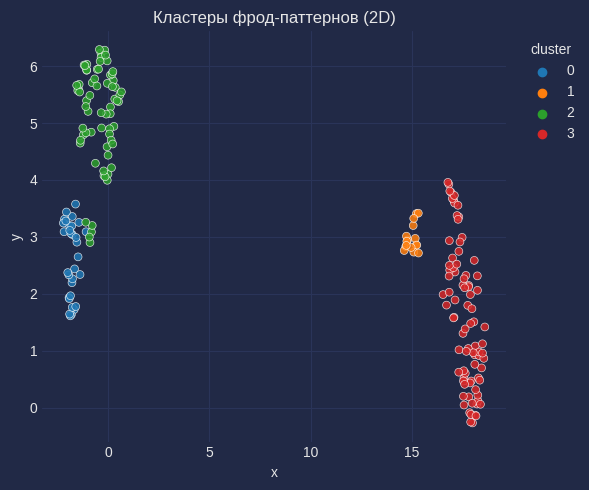

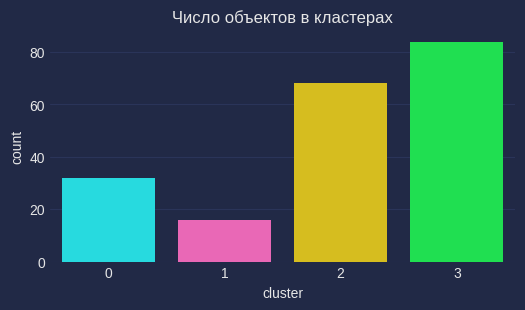

In [117]:
cl.plot_clusters(embeddings, X2, labels)

##### Вывод по кластеризации фрод-паттернов:

- Алгоритм кластеризации выделил 4 кластера, что указывает на наличие различных сценариев мошеннических диалогов.
- Наибольшее количество объектов попало в кластеры 2 и 3 (более 60 и 80 объектов соответственно), что отражает повторяющиеся и часто встречающиеся паттерны фрода.
- Кластер 0 содержит около 30 объектов, а кластер 1 всего 15, что может свидетельствовать о более редких или специфичных сценариях.
- Визуализация в 2D-проекции подтверждает чёткую разделимость между группами, что облегчает дальнейший анализ и интерпретацию выявленных фрод-сценариев.

In [119]:
cl.show_cluster_examples(embeddings, df_cand, labels, best_cfg, top_k=12)

,cluster,terms
0,cluster_0,"[code, код, алло, номер, буду, ничего, call_ended, code_request, подтвердите, здравствуйте, чтобы, сч]"
1,cluster_1,"[то, алло, вот, номер, вс, мне, тебя, пожалуйста, так, телефона, алло алло, могу]"
2,cluster_2,"[здравствуйте, спасибо, без, можем, почту, предлагаем, пришлите, приложении, через, банк, напоминаем, предложение]"
3,cluster_3,"[то, номер, мне, так, меня, хорошо, тебя, sim, алло, телефона, вот, карты]"



Кластер 0 — примеры:
— Алло, оператор МТС, напоминаем о продлении периода обслуживания вашего номера, оформим сейчас? Спасибо, не надо. Это обязательная процедура, иначе исходящие могут быть ограничены. Не интересует, до свидания. Мы лишь инфо
— Алло. Слышно нормально. Служба безопасности Сбербанка сообщает о попытке списания через быстрые платежи, подтверждали ли что-то. Нет, ничего не подтверждал. Для отмены потребуется сверка владельца, иначе операция уйдёт в
— Алло, Мосэнергосбыт, просрочена поверка счётчика, оформим замену, пришлю ссылку на оплату и код подтверждения. Нет, приходите с письменным уведомлением, по телефону ничего делать не буду. Это льготная запись, мест мало, 
— Здравствуйте, Почта Банк, перевыпустим карту по процедуре, требуется временный перевод на технический счёт. Нет, спасибо, ничего переводить не буду. Тогда сохраняем риск списаний. До свидания. Звонок завершён.
— Алло, портал Госуслуги. Вы отмечены для дополнительного подтверждения, чтобы не ограничили дост

##### Вывод по содержанию кластеров:

- **Кластер 0** отражает типичные сценарии фрода, связанные с банками, госуслугами и коммунальными компаниями. Здесь активно используются коды подтверждения, номера карт и паспортные данные, а также упоминается завершение звонка. Этот кластер наиболее близок к классическим фишинговым и социально-инженерным атакам.
- **Кластер 1** содержит фрагменты разговоров с образовательными учреждениями и регистраторами. Отличается обилием слов «алло», «пожалуйста», «телефон», в диалогах часто встречаются вопросы про электронные журналы, дневники, регистратуры. Это может быть более «размытая» группа с менее структурированными и часто сбивающимися диалогами.
- **Кластер 2** группирует преимущественно нейтральные сервисные взаимодействия (банки, страховые, почтовые и курьерские службы). Здесь заметно больше вежливых и деловых слов («здравствуйте», «спасибо», «предлагаем», «пришлите», «приложении»). Такие паттерны ближе к «нормальным» сценариям общения, но тоже могут использоваться мошенниками для маскировки.
- **Кластер 3** объединяет агрессивные и конфликтные разговоры с упоминанием SIM-карт, телефонов и карт. Встречается грубая речь, перебивания и эмоциональная окраска («в своём уме», ругательства, оскорбления). Кластер фиксирует более «шумные» и нестандартные случаи, характерные для обострённых мошеннических или псевдо-служебных диалогов.

Таким образом, кластеризация позволила разделить данные на группы по типам коммуникации: от классического фрода с кодами и документами (кластер 0) до эмоциональных и конфликтных сценариев (кластер 3), а также выделить сервисные (кластер 2) и «размытые образовательные» (кластер 1) кейсы.

In [121]:
metrics_df = cl.clustering_metrics_summary(embeddings, labels)
print("Метрики кластеризации:")
display(metrics_df)

Размеры кластеров:


cluster,0,1,2,3
count,32,16,68,84


Метрики кластеризации:


,metric,value
0,silhouette,0.169800
1,calinski_harabasz,36.197745
2,davies_bouldin,2.182337


In [123]:
_ = cl.projection_trustworthiness(embeddings, X2, n_neighbors=10)

Trustworthiness(2D) при k=10: 0.935


##### Вывод по результатам кластеризации:

- Размеры кластеров распределены неравномерно: кластер 3 оказался крупнейшим (84 объекта), за ним следует кластер 2 (68 объектов), а кластеры 0 и 1 значительно меньше (32 и 16 объектов соответственно). Это указывает на то, что в данных есть как массовые типовые сценарии (кластеры 2 и 3), так и более редкие, но важные группы (кластеры 0 и 1).
- Метрики кластеризации:
    - **Silhouette = 0.17** — довольно низкое значение, указывающее на то, что кластеры частично пересекаются и не имеют чётких границ.
    - **Calinski–Harabasz = 36.2** — относительно невысокий показатель, что также подтверждает умеренную структурированность данных.
    - **Davies–Bouldin = 2.18** — выше желательного уровня (<1), то есть внутрикластерная компактность не очень высокая, а межкластерные различия не всегда чётко выражены.
- **Trustworthiness(2D) при k=10 = 0.935** — высокая метрика доверительности для двумерного отображения, что говорит о корректном сохранении структуры данных при понижении размерности (UMAP).

Подводя итог, кластеризация выявила закономерные группы паттернов, но разделение не является идеально чётким. Это связано с близостью сценариев друг к другу, а также с шумом и разнообразием в исходных текстах. Результаты можно считать рабочими для анализа фрод-паттернов, хотя качество кластеров ограничено сложностью данных.

Устойчивость кластеров (ARI):


,count,mean,std,min,25%,50%,75%,max
run,8.0,4.500000,2.449490,1.000000,2.750000,4.500000,6.250000,8.000000
ari,8.0,0.956484,0.015027,0.937141,0.947041,0.956426,0.966645,0.975858
n,8.0,180.000000,0.000000,180.000000,180.000000,180.000000,180.000000,180.000000


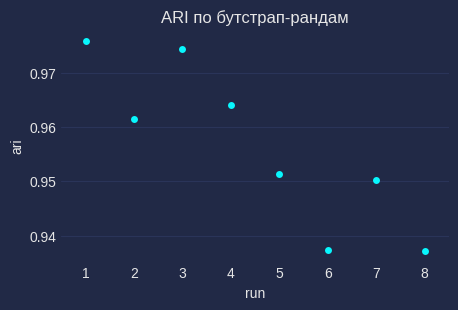

In [124]:
if len(np.unique(labels[labels!=-1])) >= 2:
    n_k = len(np.unique(labels[labels!=-1])) if (-1 in labels) else len(np.unique(labels))
    _ = cl.clustering_stability_ari(embeddings, labels, n_clusters=n_k, n_runs=8, sample_frac=0.9)
else:
    print("Недостаточно кластеров для проверки устойчивости")

##### Вывод по устойчивости кластеров (ARI):

- Среднее значение ARI по 8 перезапускам составило $0.956$, что указывает на высокую устойчивость кластеров: разбиения почти совпадают даже при бутстрап-рандомизации.
- Разброс значений небольшой ($std ≈ 0.015$), а диапазон — от $0.937$ до $0.976$, что подтверждает стабильность структуры.
- Это означает, что несмотря на невысокие значения внутренних метрик (silhouette, DBI), сами кластеры воспроизводимы и не зависят от случайных инициализаций.
- Можно считать, что выделенные кластеры отражают устойчивые паттерны данных, и дальнейший анализ по ним оправдан.

## Заключение (Autro)

##### Итоговое заключение  

В рамках задачи от МТС-Защитник была проведена работа по классификации и кластеризации телефонного мошенничества. Цель проекта — создание инструмента, позволяющего выявлять мошеннические звонки и анализировать их паттерны для использования банками и правоохранительными органами.  

##### Подготовка данных  
• Собран и обработан датасет мошеннических и немошеннических звонков.
• Проведена анонимизация и маскирование чувствительных сущностей.
• Несмотря на найденные неточности в маскировании, итоговое качество корпуса позволило обучить рабочие модели.  

##### Классификация звонков  
• Использована модель DeepPavlov/rubert-base-cased-conversational с LoRA-адаптацией и BCEWithLogitsLoss.
• Результат на lockbox-тесте: ($PR\text{-}AUC ≈ 0.819$), ($Precision ≈ 0.83$), ($F1 ≈ 0.67$).
• Рассматривалась также более крупная модель ruRoberta-large от Сбера, которая показывала ($PR\text{-}AUC ≈ 0.91$) даже без подбора порога.  
• Однако из-за ограничений Kaggle по оперативной памяти обучение на ruRoberta-large приводило к падению ядра. Для корректной работы требовались бы доработки кода, которую я бы не успел разобрать и реализовать за оставшееся время. В связи с ограничением по времени эти изменения не были внесены, поэтому для итоговой версии использовалась более лёгкая модель, под которую всё изначально и делал.  

##### Кластеризация мошеннических паттернов  
• Выделено 4 кластера, отражающие разные сценарии: от «службы безопасности банка» до образовательных и псевдослужебных звонков. 
• Размеры кластеров варьировались от ($16$) до ($84$) объектов.
• Метрики кластеризации: ($Silhouette ≈ 0.17$), ($DBI ≈ 2.18$). 
• Проверка устойчивости показала высокую воспроизводимость: ($ARI ≈ 0.956$), что подтверждает стабильность выделенных паттернов.

##### Дальнейшие направления развития  
• Оптимизация работы с большими моделями (ruRoberta-large) с внедрением градиентной аккумуляции, контрольных чекпоинтов и более эффективного управления памятью.
• Расширение корпуса данных и улучшение маскирования чувствительных сущностей.
• Возможность выноса общих функций (токенизация, подсчёт длин, подготовка эмбеддингов) в отдельные скрипты для повторного использования в пайплайне.
• Исследование мультимодальных подходов (текст + голосовые признаки).

##### Общий вывод  
Даже на открытых данных удалось построить классификатор с приемлемыми показателями качества и выделить устойчивые паттерны мошеннических звонков. Результаты подтверждают практическую ценность подхода и потенциал применения ML в задачах антифрода.  